# Peptic Ulcer Detection – Hybrid CNN + Transformer
### Balanced Augmentation + Focal Loss + Grad-CAM
**TensorFlow: Using Colab Default (2.15+)**

In [1]:
# Minimal installs (no TensorFlow Addons needed)
!pip install -q opencv-python-headless seaborn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os, glob, random
import numpy as np
import tensorflow as tf
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset_path = '/content/drive/MyDrive/DATASET'
IMG_SIZE = (192,192)
BATCH = 24
EPOCHS = 30
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [4]:
class_names = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path,d))])
num_classes = len(class_names)
class_to_idx = {c:i for i,c in enumerate(class_names)}
all_paths, all_labels = [], []
for c in class_names:
    for f in glob.glob(os.path.join(dataset_path, c, '*')):
        all_paths.append(f)
        all_labels.append(class_to_idx[c])
all_paths = np.array(all_paths)
all_labels = np.array(all_labels)
len(all_paths)

3177

In [5]:
train_paths, train_labels, val_paths, val_labels = [], [], [], []
val_ratio = 0.2
for cls in range(num_classes):
    cls_mask = all_labels == cls
    cls_imgs = all_paths[cls_mask]
    cls_labs = all_labels[cls_mask]
    idxs = np.arange(len(cls_imgs)); np.random.shuffle(idxs)
    split = int(len(cls_imgs)*(1-val_ratio))
    train_paths.extend(cls_imgs[:split])
    train_labels.extend(cls_labs[:split])
    val_paths.extend(cls_imgs[split:])
    val_labels.extend(cls_labs[split:])
train_paths, train_labels = np.array(train_paths), np.array(train_labels)
val_paths, val_labels = np.array(val_paths), np.array(val_labels)
len(train_paths), len(val_paths)

(2540, 637)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

def load_preprocess(path, label, aug=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    if aug:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, 0.15)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        k = tf.random.uniform([], 0, 4, dtype=tf.int32)
        img = tf.image.rot90(img, k)

    return img, tf.one_hot(label, num_classes)

train_sets = []
for cls in range(num_classes):
    mask = train_labels==cls
    ds = tf.data.Dataset.from_tensor_slices((train_paths[mask], train_labels[mask]))
    ds = ds.shuffle(500).repeat().map(lambda p,l: load_preprocess(p,l,True), AUTOTUNE)
    train_sets.append(ds)

train_ds = tf.data.Dataset.sample_from_datasets(train_sets, weights=[1/num_classes]*num_classes)
train_ds = train_ds.batch(BATCH).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths,val_labels))
val_ds = val_ds.map(lambda p,l: load_preprocess(p,l,False), AUTOTUNE)
val_ds = val_ds.batch(BATCH).prefetch(AUTOTUNE)

train_steps = len(train_paths)//BATCH
val_steps = len(val_paths)//BATCH
train_steps, val_steps

(105, 26)

In [7]:
class_counts = np.bincount(train_labels, minlength=num_classes)
freq = class_counts/np.sum(class_counts)
alpha_vec = (1-freq)/np.sum(1-freq)

def focal_loss(gamma=2.0, alpha=None):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred,1e-7,1-1e-7)
        ce = -y_true*tf.math.log(y_pred)

        ce = ce*alpha
        weight = tf.pow(1-y_pred,gamma)
        return tf.reduce_sum(weight*ce,axis=1)
    return loss

loss_fn = focal_loss(alpha=alpha_vec)
alpha_vec

array([0.41358268, 0.16062992, 0.4257874 ])

In [ ]:
class_counts = np.bincount(train_labels, minlength=num_classes)
freq = class_counts/np.sum(class_counts)
alpha_vec = (1-freq)/np.sum(1-freq)

def focal_loss(gamma=2.0, alpha=None):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred,1e-7,1-1e-7)
        ce = -y_true*tf.math.log(y_pred)

        ce = ce*alpha
        weight = tf.pow(1-y_pred,gamma)
        return tf.reduce_sum(weight*ce,axis=1)
    return loss

loss_fn = focal_loss(alpha=alpha_vec)
alpha_vec

array([0.41358268, 0.16062992, 0.4257874 ])

In [19]:
class_counts = np.bincount(train_labels, minlength=num_classes)
freq = class_counts/np.sum(class_counts)
alpha_vec = (1-freq)/np.sum(1-freq)

def focal_loss(gamma=2.0, alpha=None):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred,1e-7,1-1e-7)
        ce = -y_true*tf.math.log(y_pred)
        alpha_factor=tf.reduce_sum(alpha * y_true, axis=1, keepdims=True)
        ce = ce*alpha_factor
        weight = tf.pow(1-y_pred,gamma)
        return tf.reduce_sum(weight*ce,axis=1)
    return loss

loss_fn = focal_loss(alpha=alpha_vec)
alpha_vec

array([0.41358268, 0.16062992, 0.4257874 ])

In [8]:
def transformer_block(x, heads=4, ff_dim=256):
    # LayerNorm → Attention → Residual
    attn_input = LayerNormalization(epsilon=1e-6)(x)
    attn_output = MultiHeadAttention(
        num_heads=heads,
        key_dim=x.shape[-1]
    )(attn_input, attn_input)
    x = x + attn_output

    # LayerNorm → Feed Forward → Residual
    ff_input = LayerNormalization(epsilon=1e-6)(x)
    ff_output = Dense(ff_dim, activation='relu')(ff_input)
    ff_output = Dense(x.shape[-1])(ff_output)
    return x + ff_output


# ---------- FIXED MODEL (NO TF OP ERRORS) ----------
def build_model():
    inp = Input((IMG_SIZE[0],IMG_SIZE[1],3))

    # Base CNN
    base = ResNet50(include_top=False, weights='imagenet')
    base.trainable = False
    x = base(inp)

    # Project features
    x = Dense(256, activation='relu')(x)

    # ☠  FIX: Use Keras Reshape Layer instead of tf.reshape
    h, w, c = x.shape[1], x.shape[2], x.shape[3]      # symbolic dims
    x = tf.keras.layers.Reshape((h*w, c))(x)         # (B, H*W, C)

    # Transformer block
    x = transformer_block(x)

    # Global pooling over sequence
    x = GlobalAveragePooling1D()(x)

    # Dense head
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    out = Dense(num_classes, activation='softmax')(x)

    return Model(inp, out)


# Build model
model = build_model()
model.compile(optimizer=Adam(1e-4), loss=loss_fn, metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 192, 192,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 6, 6,      │ 23,587,712 │ input_layer[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 6, 6, 256) │    524,544 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 36, 256)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 36, 256)   │        512 │ reshape[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 36, 256)   │  1,051,904 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 36, 256)   │          0 │ reshape[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 36, 256)   │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 36, 256)   │     65,792 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 36, 256)   │     65,792 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 36, 256)   │          0 │ add[0][0],        │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 3)         │        771 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,363,331 (96.75 MB)

 Trainable params: 1,775,619 (6.77 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
import cv2
import numpy as np

# We treat the OUTPUT of ResNet50 (include_top=False) as the "last conv layer"
# This avoids nested layer name confusion and is simpler.
conv_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer("resnet50").output  # shape: (B, h, w, c)
)

IMG_H, IMG_W = IMG_SIZE


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ---- Phase 1: Train transformer + dense head with ResNet50 frozen ----
base = model.get_layer('resnet50')
base.trainable = False  # just to be explicit

ckpt = ModelCheckpoint('/content/best_model_phase1.h5',
                       save_best_only=True,
                       monitor='val_accuracy',
                       verbose=1)
es = EarlyStopping(monitor='val_loss',
                   patience=5,
                   restore_best_weights=True,
                   verbose=1)

print(">>> Phase 1: Training head with frozen ResNet50")
history1 = model.fit(
    train_ds,
    epochs=15,                       # warmup
    steps_per_epoch=train_steps,
    validation_data=val_ds,
    validation_steps=val_steps,
    callbacks=[ckpt, es]
)

# ---- Phase 2: Fine-tune top ResNet50 layers with small LR ----
print(">>> Phase 2: Fine-tuning top ResNet50 blocks")

base.trainable = True
# Freeze most layers, unfreeze last ~50 for fine-tuning
for layer in base.layers[:-20]:
    layer.trainable = False

# Recompile with smaller LR (very important for fine-tuning)
model.compile(
    optimizer=Adam(1e-5),
    loss=loss_fn,
    metrics=['accuracy']
)

ckpt_ft = ModelCheckpoint('/content/best_model_finetuned.h5',
                          save_best_only=True,
                          monitor='val_accuracy',
                          verbose=1)
es_ft = EarlyStopping(monitor='val_loss',
                      patience=5,
                      restore_best_weights=True,
                      verbose=1)

history2 = model.fit(
    train_ds,
    epochs=35,                       # fine-tune longer
    steps_per_epoch=train_steps,
    validation_data=val_ds,
    validation_steps=val_steps,
    callbacks=[ckpt_ft, es_ft]
)


>>> Phase 1: Training head with frozen ResNet50
Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3240 - loss: 0.1980
Epoch 1: val_accuracy improved from -inf to 0.16026, saving model to /content/best_model_phase1.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 530s 5s/step - accuracy: 0.3241 - loss: 0.1977 - val_accuracy: 0.1603 - val_loss: 0.1360
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3753 - loss: 0.1411
Epoch 2: val_accuracy improved from 0.16026 to 0.48397, saving model to /content/best_model_phase1.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 482s 5s/step - accuracy: 0.3756 - loss: 0.1410 - val_accuracy: 0.4840 - val_loss: 0.1035
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5426 - loss: 0.1124
Epoch 3: val_accuracy improved from 0.48397 to 0.70353, saving model to /content/best_model_phase1.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 436s 4s/step - accuracy: 0.5427 - loss: 0.1123 - val_accuracy: 0.7035 - val_loss: 0.0848
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5765 - loss: 0.0995
Epoch 4: val_accuracy improved from 0.70353 to 0.77244, saving model to /content/best_model_phase1.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 449s 4s/step - accuracy: 0.5767 - loss: 0.0995 - val_accuracy: 0.7724 - val_loss: 0.0673
Epoch 5/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6048 - loss: 0.0993
Epoch 5: val_accuracy did not improve from 0.77244
105/105 ━━━━━━━━━━━━━━━━━━━━ 436s 4s/step - accuracy: 0.6051 - loss: 0.0993 - val_accuracy: 0.7660 - val_loss: 0.0742
Epoch 6/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6604 - loss: 0.0965
Epoch 6: val_accuracy did not improve from 0.77244
105/105 ━━━━━━━━━━━━━━━━━━━━ 442s 4s/step - accuracy: 0.6605 - loss: 0.0965 - val_accuracy: 0.7548 - val_loss: 0.0832
Epoch 7/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7002 - loss: 0.0874
Epoch 7: val_accuracy did not improve from 0.77244
105/105 ━━━━━━━━━━━━━━━━━━━━ 434s 4s/step - accuracy: 0.7002 - loss: 0.0873 - val_accuracy: 0.7644 - val_loss: 0.0837
Epoch 8/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6841 - loss: 0.0887
Epoch 8: val_accuracy did not impro

105/105 ━━━━━━━━━━━━━━━━━━━━ 436s 4s/step - accuracy: 0.7755 - loss: 0.0625 - val_accuracy: 0.7821 - val_loss: 0.0735
Epoch 13/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7722 - loss: 0.0679
Epoch 13: val_accuracy improved from 0.78205 to 0.83974, saving model to /content/best_model_phase1.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 426s 4s/step - accuracy: 0.7723 - loss: 0.0679 - val_accuracy: 0.8397 - val_loss: 0.0579
Epoch 14/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7774 - loss: 0.0660
Epoch 14: val_accuracy did not improve from 0.83974
105/105 ━━━━━━━━━━━━━━━━━━━━ 442s 4s/step - accuracy: 0.7775 - loss: 0.0660 - val_accuracy: 0.7917 - val_loss: 0.0991
Epoch 15/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8441 - loss: 0.0516
Epoch 15: val_accuracy did not improve from 0.83974
105/105 ━━━━━━━━━━━━━━━━━━━━ 420s 4s/step - accuracy: 0.8440 - loss: 0.0517 - val_accuracy: 0.8109 - val_loss: 0.0888
Restoring model weights from the end of the best epoch: 13.
>>> Phase 2: Fine-tuning top ResNet50 blocks
Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6466 - loss: 0.1221
Epoch 1: val_accuracy improved from -inf to 0.17628, saving model to /content/best_model_finetuned.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 625s 6s/step - accuracy: 0.6476 - loss: 0.1217 - val_accuracy: 0.1763 - val_loss: 1.0564
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8461 - loss: 0.0495
Epoch 2: val_accuracy improved from 0.17628 to 0.17788, saving model to /content/best_model_finetuned.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 622s 6s/step - accuracy: 0.8462 - loss: 0.0495 - val_accuracy: 0.1779 - val_loss: 0.8040
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9130 - loss: 0.0301
Epoch 3: val_accuracy improved from 0.17788 to 0.22917, saving model to /content/best_model_finetuned.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 602s 6s/step - accuracy: 0.9128 - loss: 0.0301 - val_accuracy: 0.2292 - val_loss: 0.2463
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8810 - loss: 0.0343
Epoch 4: val_accuracy improved from 0.22917 to 0.75000, saving model to /content/best_model_finetuned.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 610s 6s/step - accuracy: 0.8810 - loss: 0.0343 - val_accuracy: 0.7500 - val_loss: 0.0599
Epoch 5/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9439 - loss: 0.0165
Epoch 5: val_accuracy improved from 0.75000 to 0.86058, saving model to /content/best_model_finetuned.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 606s 6s/step - accuracy: 0.9438 - loss: 0.0166 - val_accuracy: 0.8606 - val_loss: 0.0582
Epoch 6/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8922 - loss: 0.0304
Epoch 6: val_accuracy did not improve from 0.86058
105/105 ━━━━━━━━━━━━━━━━━━━━ 622s 6s/step - accuracy: 0.8922 - loss: 0.0304 - val_accuracy: 0.8173 - val_loss: 0.0814
Epoch 7/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9255 - loss: 0.0236
Epoch 7: val_accuracy did not improve from 0.86058
105/105 ━━━━━━━━━━━━━━━━━━━━ 612s 6s/step - accuracy: 0.9256 - loss: 0.0236 - val_accuracy: 0.6731 - val_loss: 0.1098
Epoch 8/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9153 - loss: 0.0235
Epoch 8: val_accuracy did not improve from 0.86058
105/105 ━━━━━━━━━━━━━━━━━━━━ 613s 6s/step - accuracy: 0.9153 - loss: 0.0235 - val_accuracy: 0.8333 - val_loss: 0.0853
Epoch 9/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9280 - loss: 0.0181
Epoch 9: val_accuracy did not impro

105/105 ━━━━━━━━━━━━━━━━━━━━ 626s 6s/step - accuracy: 0.9253 - loss: 0.0198 - val_accuracy: 0.8830 - val_loss: 0.0854
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.


              precision    recall  f1-score   support

         AVM       0.83      0.65      0.72       110
      Normal       0.95      0.95      0.95       432
       Ulcer       0.70      0.89      0.78        95

    accuracy                           0.89       637
   macro avg       0.83      0.83      0.82       637
weighted avg       0.89      0.89      0.89       637



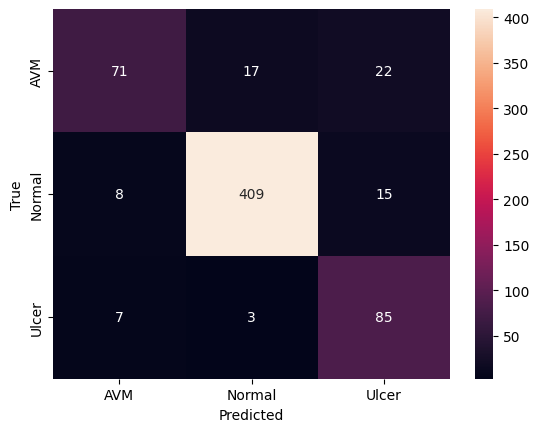

In [18]:
y_true = []
y_pred = []

for imgs, labs in val_ds:
    probs = model.predict(imgs, verbose=0)

    for i in range(len(probs)):
        # true label
        y_true.append(np.argmax(labs[i].numpy()))

        # class-wise thresholding
        if probs[i][2] > 0.60:          # Ulcer threshold
            y_pred.append(2)
        elif probs[i][0] > 0.40:        # AVM threshold
            y_pred.append(0)
        else:
            y_pred.append(1)            # Normal

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [12]:
# ---------- Gradient-based Saliency (Grad-CAM-like) ----------
def compute_saliency_map(input_image, target_class=None):
    """
    input_image: np array or tensor of shape (1, 150, 150, 3) in [0,1]
    target_class: class index (int); if None -> use predicted class

    Returns:
        saliency: (150, 150) map in [0,1]
    """
    # Ensure tensor and enable gradient
    x = tf.convert_to_tensor(input_image, dtype=tf.float32)
    x = tf.Variable(x)  # let gradients flow w.r.t input

    with tf.GradientTape() as tape:
        tape.watch(x)
        preds = model(x, training=False)    # (1, num_classes)
        if target_class is None:
            target_class = tf.argmax(preds[0])
        score = preds[:, target_class]      # scalar score for that class

    # Gradient of class score with respect to input pixels
    grads = tape.gradient(score, x)[0].numpy()   # (150,150,3)

    # Take max over channels (standard saliency trick)
    saliency = np.max(np.abs(grads), axis=-1)    # (150,150)

    # Normalize to [0,1]
    saliency = saliency - saliency.min()
    saliency = saliency / (saliency.max() + 1e-8)

    return saliency


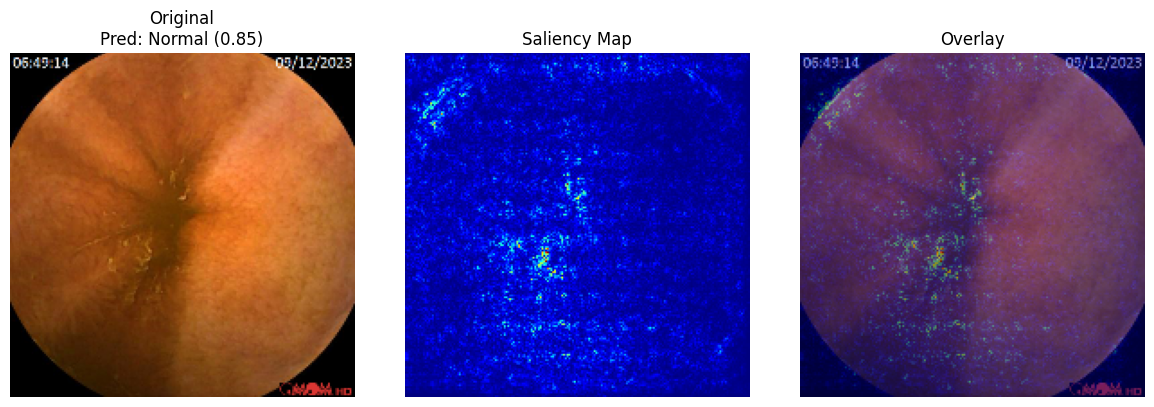

In [13]:
# ---------- Visualize saliency for a random validation image ----------
path = random.choice(val_paths)

img_bgr = cv2.imread(path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_rgb = cv2.resize(img_rgb, IMG_SIZE)
img_norm = img_rgb.astype(np.float32) / 255.0   # (150,150,3)
inp = np.expand_dims(img_norm, axis=0)          # (1,150,150,3)

# Get model prediction
preds = model(inp)[0].numpy()
pred_class = np.argmax(preds)
pred_name = class_names[pred_class]
conf = preds[pred_class]

# Compute saliency map
saliency = compute_saliency_map(inp, target_class=pred_class)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_norm)
plt.title(f"Original\nPred: {pred_name} ({conf:.2f})")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(saliency, cmap="jet")
plt.title("Saliency Map")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img_norm)
plt.imshow(saliency, cmap="jet", alpha=0.45)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()
